references:
1. Pytorch documentation / tutorials https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
2. https://www.youtube.com/watch?v=5rW_PZI4B2I
3. https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import transforms,datasets

import matplotlib.pyplot as plt
from sklearn import model_selection
import numpy as np
import pandas as pd
from pathlib import Path 
from imageio import imread
import timeit
import time
import shutil

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# def split_train_validation():
#   train_folder = Path('/content/drive/My Drive/cs175_data/train')
#   X = []
#   Y = []

#   for classname in train_folder.iterdir():
#     for img in classname.iterdir():
#       X.append(img)
#       Y.append(classname.name)

#   Xtr, Xva, Ytr, Yva = model_selection.train_test_split(X, Y, test_size=0.25, random_state=20)
#   for i in range(len(Xva)):
#     shutil.move(str(Xva[i]), '/content/drive/My Drive/cs175_data/validation/' + Yva[i])

# split_train_validation()

In [3]:
class_dict = {"c0":"safe driving","c1":"texting - right","c2":"talking on the phone - right",
              "c3":"texting - left","c4":"talking on the phone - left","c5":"operating the radio",
              "c6":"drinking", "c7":"reaching behind","c8":"hair and makeup","c9":"talking to passenger"}

In [4]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
                                      transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
                                      transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
train_dataset = datasets.ImageFolder("../data/imgs/train", transform = data_transforms['train'])
validation_dataset = datasets.ImageFolder("../data/imgs/validation", transform = data_transforms['validation'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size =32, shuffle=True, drop_last=True)

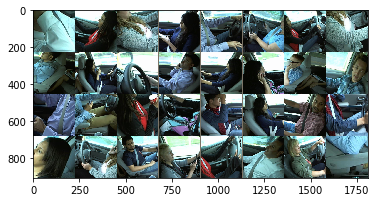

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, _ = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out)

# data training

In [33]:
print_every = 100
np.random.seed(2020)
# torch.cuda.random.manual_seed(12345)
gpu_dtype = torch.FloatTensor

def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(train_loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch > 12 and epoch % 2 == 0:
            check_accuracy(model)
            
def check_accuracy(model):
    print('Checking accuracy on validation set')  
    num_correct = 0
    num_samples = 0
    model.eval()
    for x, y in val_loader:
        x_var = Variable(x.type(gpu_dtype))

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

device = torch.device(0)
class_names = train_dataset.classes

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_dict[class_names[preds[j]]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=12, stride=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(8),
    nn.Conv2d(8, 16, kernel_size=24, stride=2),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2,stride=2),
    nn.Flatten(),
    nn.Linear(35344, 1376),
    nn.ReLU(inplace=True),
    nn.Linear(1376, 10)
).type(gpu_dtype)

In [21]:
x = torch.randn(64, 3, 224, 224)
x_var = Variable(x.type(gpu_dtype))
ans = model(x_var)

np.array(ans.size())

array([64, 10])

In [34]:
model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=12, stride=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(8),
    nn.Conv2d(8, 16, kernel_size=24, stride=2),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2,stride=2),
    nn.Flatten(),
    nn.Linear(35344, 1376),
    nn.ReLU(inplace=True),
    nn.Linear(1376, 10)
).type(gpu_dtype)

t = time.time()
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.Adadelta(model.parameters(), lr=1e-1)
train(model, loss_fn, optimizer, num_epochs=20)
print('time used:', time.time() - t)
check_accuracy(model)

Starting epoch 1 / 20
t = 100, loss = 2.2727
t = 200, loss = 2.2579
t = 300, loss = 2.2274
t = 400, loss = 2.0386
t = 500, loss = 2.1499
Starting epoch 2 / 20
t = 100, loss = 2.0543
t = 200, loss = 2.0260
t = 300, loss = 2.0096
t = 400, loss = 1.8672
t = 500, loss = 1.8042
Starting epoch 3 / 20
t = 100, loss = 1.4823
t = 200, loss = 1.8924
t = 300, loss = 2.0461
t = 400, loss = 1.5499
t = 500, loss = 1.5456
Starting epoch 4 / 20
t = 100, loss = 1.6874
t = 200, loss = 1.6244
t = 300, loss = 1.7425
t = 400, loss = 1.4115
t = 500, loss = 1.6305
Starting epoch 5 / 20
t = 100, loss = 1.3953
t = 200, loss = 1.5632
t = 300, loss = 1.3225
t = 400, loss = 1.5082
t = 500, loss = 1.4032
Starting epoch 6 / 20
t = 100, loss = 1.2099
t = 200, loss = 1.4054
t = 300, loss = 1.1771
t = 400, loss = 1.2037
t = 500, loss = 1.1248
Starting epoch 7 / 20
t = 100, loss = 1.6930
t = 200, loss = 1.1302
t = 300, loss = 1.0414
t = 400, loss = 1.3889
t = 500, loss = 1.4156
Starting epoch 8 / 20
t = 100, loss = 0.7

## save model

In [35]:
torch.save(model.state_dict(), "../best_model_cpu.pt")

# data testing

In [36]:
best_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=12, stride=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(8),
    nn.Conv2d(8, 16, kernel_size=24, stride=2),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2,stride=2),
    nn.Flatten(),
    nn.Linear(35344, 1376),
    nn.ReLU(inplace=True),
    nn.Linear(1376, 10)
).type(gpu_dtype)
best_model.load_state_dict(torch.load("../best_model_cpu.pt"))
best_model.eval()

Sequential(
  (0): Conv2d(3, 8, kernel_size=(12, 12), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(8, 16, kernel_size=(24, 24), stride=(2, 2))
  (4): ReLU(inplace=True)
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten()
  (8): Linear(in_features=35344, out_features=1376, bias=True)
  (9): ReLU(inplace=True)
  (10): Linear(in_features=1376, out_features=10, bias=True)
)

In [37]:
check_accuracy(best_model)

Checking accuracy on validation set
Got 5289 / 5600 correct (94.45)


In [38]:
class MyImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        return super(MyImageFolder, self).__getitem__(index), self.imgs[index]

test_dataset = MyImageFolder("../data/imgs/test/", transform = data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size =1, shuffle=True)

In [39]:
sm = torch.nn.Softmax(dim=0)
result = []
count = 0
for data in test_loader:
  count += 1
  (x,y),(path,_) = data
  x_var = Variable(x.type(gpu_dtype))
  score = best_model(x_var)
  result.append([Path(path[0]).name] + sm(score[0]).tolist())
  if count % 10000 == 0:
    print(count)
print(count)

10000
20000
30000
40000
50000
60000
70000
79726


In [40]:
column_names = ['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
df = pd.DataFrame(result, columns = column_names)
df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_92393.jpg,7.091096e-08,1.480631e-07,5.299152e-06,7.013740e-11,5.623807e-09,2.960014e-08,1.466477e-07,9.997910e-01,0.000187,0.000016
1,img_58468.jpg,9.979873e-01,3.253578e-04,1.864739e-07,4.641671e-06,1.365438e-07,5.795300e-07,5.789067e-08,1.545103e-07,0.000001,0.001681
2,img_2319.jpg,3.499877e-06,7.643949e-03,9.881493e-01,1.809524e-05,3.367071e-05,1.867014e-06,7.783091e-04,9.704220e-05,0.001793,0.001481
3,img_8669.jpg,6.916035e-03,9.680605e-01,1.227340e-04,4.529329e-06,2.979404e-07,7.459620e-08,5.440790e-04,6.724604e-05,0.000131,0.024153
4,img_15924.jpg,5.958344e-01,7.328084e-07,2.536034e-09,3.335316e-05,3.384024e-01,5.150199e-04,2.275564e-05,7.430505e-03,0.000003,0.057758
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_24898.jpg,2.090217e-01,1.994246e-03,2.073172e-05,3.633271e-06,9.450213e-10,7.886351e-01,6.406869e-07,4.187347e-05,0.000127,0.000155
79722,img_8069.jpg,8.496214e-01,1.639455e-03,7.213813e-07,4.694541e-02,4.051207e-04,9.373876e-06,4.877387e-07,9.047272e-10,0.000087,0.101291
79723,img_89828.jpg,4.931861e-04,2.417424e-06,6.770336e-10,1.835108e-04,9.983382e-01,7.763628e-08,7.248594e-09,3.145478e-07,0.000003,0.000979
79724,img_24333.jpg,9.997316e-01,5.597200e-06,6.599134e-08,1.207734e-07,2.628782e-08,5.001874e-07,1.131333e-08,8.922842e-11,0.000016,0.000246


In [41]:
df.to_csv('test.csv',index=False)

# ACCURACY 95.7%

In [0]:
model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=12, stride=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(8),
    nn.Conv2d(8, 16, kernel_size=24, stride=2),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2,stride=2),
    nn.Flatten(),
    nn.Linear(35344, 1376),
    nn.ReLU(inplace=True),
    nn.Linear(1376, 10)
).type(gpu_dtype)

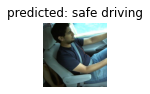

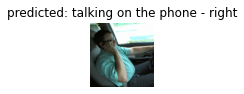

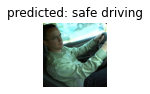

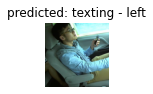

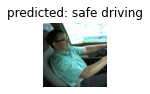

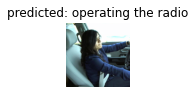

In [0]:
visualize_model(model,6)